In [1]:
import pandas as pd
import codecs
import numpy as np
import math
import csv
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import recall_score, precision_score # New
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import matplotlib.pyplot as plt
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
from keijzer import *
import math

In [2]:
data_path = 'C:/Users/smartgrid_AI/Desktop/windpower_ramprate/ercot_2020.csv'
data_source1 = pd.read_csv(data_path)
dat_source1 = pd.DataFrame(data_source1)
#dat_source1 = dat_source1.iloc[:-3,:]

data_path = 'C:/Users/smartgrid_AI/Desktop/windpower_ramprate/ercot_2021.csv'
data_source2 = pd.read_csv(data_path)
dat_source2 = pd.DataFrame(data_source2)
dat_source2 = dat_source2.iloc[:8761,:9]

data_path = 'C:/Users/smartgrid_AI/Desktop/windpower_ramprate/ercot_2022.csv'
data_source3 = pd.read_csv(data_path)
dat_source3 = pd.DataFrame(data_source3)
dat_source3 = dat_source3.iloc[:8760,:9]

data_path = 'C:/Users/smartgrid_AI/Desktop/windpower_ramprate/ercot_2023.csv'
data_source4 = pd.read_csv(data_path)
dat_source4 = pd.DataFrame(data_source4)
dat_source4 = dat_source4.iloc[:8760,:9]

dat_arr1 = np.array(dat_source1)
dat_arr2 = np.array(dat_source2)
dat_arr3 = np.array(dat_source3)
dat_arr4 = np.array(dat_source4)

dat_arr = np.concatenate([dat_arr1, dat_arr2, dat_arr3, dat_arr4],axis=0)
dat_arr.shape # 8784, 8761, 8760, 8760

dat_source = pd.DataFrame(dat_arr, columns=['Time-Date stamp','Date','ERCOT Load','Total Wind Output','Total Wind Installed','Wind Output, % of Load','Wind Output, % of Installed','1-hr MW change','1-hr % change'])
dat_source

,Time-Date stamp,Date,ERCOT Load,Total Wind Output,Total Wind Installed,"Wind Output, % of Load","Wind Output, % of Installed",1-hr MW change,1-hr % change
0,01-01-2020 00:00:00,Jan-01,36823,12335,27040,33.5,45.617,NaN,NaN
1,01-01-2020 01:00:00,Jan-01,36511,13300,27040,36.4,49.187,965.4,7.826
2,01-01-2020 02:00:00,Jan-01,36022,13586,27040,37.7,50.245,286.2,2.152
3,01-01-2020 03:00:00,Jan-01,35790,14107,27040,39.4,52.171,520.9,3.834
4,01-01-2020 04:00:00,Jan-01,35642,14887,27040,41.8,55.055,779.6,5.527
...,...,...,...,...,...,...,...,...,...
35060,12-31-2023 20:00:00,Dec-31,44887,17161,38631,38.23,44.42,2858,19.99
35061,12-31-2023 21:00:00,Dec-31,44013,18301,38631,41.58,47.37,1139,6.64
35062,12-31-2023 22:00:00,Dec-31,43280,18607,38631,42.99,48.17,307,1.67
35063,12-31-2023 23:00:00,Dec-31,42319,17866,38631,42.22,46.25,-741,-3.98


In [3]:
dat = pd.DataFrame()
dat['Timestamp'] = np.array(dat_source['Time-Date stamp'].iloc[1:])
dat['MW % change'] = np.array(dat_source.iloc[1:,3], dtype=float)-np.array(dat_source.iloc[0:-1,3], dtype=float)
dat['MW % change'] = np.divide(np.array(dat['MW % change']),np.array(dat_source.iloc[1:,4]))*100
dat['Total Wind Output'] = np.divide(np.array(dat_source.iloc[1:,3]), np.array(dat_source.iloc[1:,4]))

ramp_ratio = 20
load_ratio = 10
year_arr = np.concatenate([np.ones(8784)*2020, np.ones(8760)*2021, np.ones(8760)*2022, np.ones(8760)*2023])
year_df = pd.DataFrame(year_arr, columns=['Year'], dtype=int)
wind_df = pd.concat([year_df, dat], axis=1)
wind_df[-10:]

,Year,Timestamp,MW % change,Total Wind Output
35054,2023,12-31-2023 15:00:00,0.906008,0.224535
35055,2023,12-31-2023 16:00:00,1.3383,0.237918
35056,2023,12-31-2023 17:00:00,2.27279,0.260646
35057,2023,12-31-2023 18:00:00,2.26243,0.28327
35058,2023,12-31-2023 19:00:00,8.69768,0.370247
35059,2023,12-31-2023 20:00:00,7.3982,0.444229
35060,2023,12-31-2023 21:00:00,2.951,0.473739
35061,2023,12-31-2023 22:00:00,0.79211,0.48166
35062,2023,12-31-2023 23:00:00,-1.91815,0.462478
35063,2023,01-01-2024 00:00:00,-5.16942,0.410784


In [4]:
import sklearn

wind_df = wind_df.reset_index(drop=True)

std_scaler = sklearn.preprocessing.MinMaxScaler()
std_scaler_load = sklearn.preprocessing.MinMaxScaler()
std_scaler_ramp = sklearn.preprocessing.MinMaxScaler()

wind_df[['Total Wind Output']] = std_scaler.fit_transform(wind_df[['Total Wind Output']])
wind_df[['MW % change']] = std_scaler_ramp.fit_transform(wind_df[['MW % change']])
#wind_df[['Wind Change, % of Load', 'Wind Change']] = std_scaler_ramp.fit_transform(wind_df[['Wind Change, % of Load', 'Wind Change']])
wind_df = wind_df.iloc[:-1,:]
wind_df[-10:]

,Year,Timestamp,MW % change,Total Wind Output
35053,2023,12-31-2023 14:00:00,0.475470,0.281695
35054,2023,12-31-2023 15:00:00,0.540013,0.293595
35055,2023,12-31-2023 16:00:00,0.553030,0.311174
35056,2023,12-31-2023 17:00:00,0.581170,0.341026
35057,2023,12-31-2023 18:00:00,0.580858,0.370742
35058,2023,12-31-2023 19:00:00,0.774643,0.484984
35059,2023,12-31-2023 20:00:00,0.735512,0.582157
35060,2023,12-31-2023 21:00:00,0.601593,0.620917
35061,2023,12-31-2023 22:00:00,0.536583,0.631322
35062,2023,12-31-2023 23:00:00,0.454969,0.606127


In [5]:
dat_source1

,time-date stamp,Date,"ERCOT Load, MW","Total Wind Output, MW","Total Wind Installed, MW","Wind Output, % of Load","Wind Output, % of Installed",1-hr MW change,1-hr % change
0,01-01-2020 00:00:00,Jan-01,36823,12335,27040,33.5,45.617,NaN,NaN
1,01-01-2020 01:00:00,Jan-01,36511,13300,27040,36.4,49.187,965.4,7.826
2,01-01-2020 02:00:00,Jan-01,36022,13586,27040,37.7,50.245,286.2,2.152
3,01-01-2020 03:00:00,Jan-01,35790,14107,27040,39.4,52.171,520.9,3.834
4,01-01-2020 04:00:00,Jan-01,35642,14887,27040,41.8,55.055,779.6,5.527
...,...,...,...,...,...,...,...,...,...
8779,12-31-2020 19:00:00,Dec-31,49857,15165,31090,30.4,48.777,788.4,5.484
8780,12-31-2020 20:00:00,Dec-31,48800,15706,31090,32.2,50.517,540.8,3.566
8781,12-31-2020 21:00:00,Dec-31,47848,15079,31090,31.5,48.502,-626.4,-3.989
8782,12-31-2020 22:00:00,Dec-31,46123,14995,31090,32.5,48.231,-84.1,-0.558


In [10]:
data_path = 'C:/Users/smartgrid_AI/Documents/kms/windpower_ramprate/training_result_df.csv'
data_source1 = pd.read_csv(data_path)
dat_source1 = pd.DataFrame(data_source1)
dat_source1 = dat_source1.iloc[:,1:]
dat_source1.columns=["Predicted_Value", "Real_Value", "Forecasting_Error", "Initial_Predicted_Value"]

data_path = 'C:/Users/smartgrid_AI/Documents/kms/windpower_ramprate/training_ramp_result_df.csv'
data_source2 = pd.read_csv(data_path)
dat_source2 = pd.DataFrame(data_source2)
dat_source2 = dat_source2.iloc[:,1:]
dat_source2.columns=["Ramp_Predicted_Value", "Ramp_Real_Value", "Ramp_Forecasting_Error", "Ramp_Initial_Predicted_Value"]

dat_source = pd.concat([dat_source1, dat_source2], axis=1)
dat_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value
0,0.799884,0.777668,-0.022217,0.768020,0.445637,0.458694,0.013057,0.423159
1,0.749757,0.739783,-0.009974,0.732273,0.399319,0.425875,0.026556,0.388723
2,0.721444,0.721323,-0.000121,0.702248,0.456475,0.470408,0.013932,0.380181
3,0.708527,0.710285,0.001759,0.663957,0.541734,0.487425,-0.054309,0.401878
4,0.660166,0.672015,0.011849,0.624496,0.493988,0.424991,-0.068997,0.411778
...,...,...,...,...,...,...,...,...
749107,0.481707,0.475905,-0.005802,0.478220,0.476512,0.437360,-0.039152,0.420162
749108,0.473300,0.464749,-0.008550,0.465869,0.523220,0.487154,-0.036066,0.469672
749109,0.412981,0.395094,-0.017886,0.444943,0.351557,0.353038,0.001481,0.400793
749110,0.331719,0.315399,-0.016320,0.436016,0.303514,0.330019,0.026505,0.294662


In [11]:
pred = np.array(dat_source[['Predicted_Value']])
rpred = np.array(dat_source[['Ramp_Predicted_Value']])

real_value = np.array(dat_source[['Predicted_Value']])+np.array(dat_source[['Forecasting_Error']])
real_ramp_value = np.array(dat_source[['Ramp_Predicted_Value']])+np.array(dat_source[['Ramp_Forecasting_Error']])

dat_source['Real_Value'] = real_value
dat_source['Initial_Forecasting_Error'] = real_value-np.array(dat_source[['Initial_Predicted_Value']])
dat_source['Real_Ramp_Value'] = real_ramp_value
dat_source['Ramp_Initial_Forecasting_Error'] = real_value-np.array(dat_source[['Ramp_Initial_Predicted_Value']])
dat_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value,Initial_Forecasting_Error,Real_Ramp_Value,Ramp_Initial_Forecasting_Error
0,0.799884,0.777668,-0.022217,0.768020,0.445637,0.458694,0.013057,0.423159,0.009648,0.458694,0.354509
1,0.749757,0.739783,-0.009974,0.732273,0.399319,0.425875,0.026556,0.388723,0.007510,0.425875,0.351060
2,0.721444,0.721323,-0.000121,0.702248,0.456475,0.470408,0.013932,0.380181,0.019075,0.470408,0.341142
3,0.708527,0.710285,0.001759,0.663957,0.541734,0.487425,-0.054309,0.401878,0.046328,0.487425,0.308408
4,0.660166,0.672015,0.011849,0.624496,0.493988,0.424991,-0.068997,0.411778,0.047520,0.424991,0.260238
...,...,...,...,...,...,...,...,...,...,...,...
749107,0.481707,0.475905,-0.005802,0.478220,0.476512,0.437360,-0.039152,0.420162,-0.002315,0.437360,0.055743
749108,0.473300,0.464749,-0.008550,0.465869,0.523220,0.487154,-0.036066,0.469672,-0.001120,0.487154,-0.004923
749109,0.412981,0.395094,-0.017886,0.444943,0.351557,0.353038,0.001481,0.400793,-0.049849,0.353038,-0.005699
749110,0.331719,0.315399,-0.016320,0.436016,0.303514,0.330019,0.026505,0.294662,-0.120617,0.330019,0.020737


In [13]:
data_path = 'C:/Users/smartgrid_AI/Documents/kms/windpower_ramprate/test_result_df.csv'
data_source1 = pd.read_csv(data_path)
dat_source1 = pd.DataFrame(data_source1)
dat_source1 = dat_source1.iloc[:,1:]
dat_source1.columns=["Predicted_Value", "Real_Value", "Forecasting_Error", "Initial_Predicted_Value"]

data_path = 'C:/Users/smartgrid_AI/Documents/kms/windpower_ramprate/test_ramp_result_df.csv'
data_source2 = pd.read_csv(data_path)
dat_source2 = pd.DataFrame(data_source2)
dat_source2 = dat_source2.iloc[:,1:]
dat_source2.columns=["Ramp_Predicted_Value", "Ramp_Real_Value", "Ramp_Forecasting_Error", "Ramp_Initial_Predicted_Value"]

test_source = pd.concat([dat_source1, dat_source2], axis=1)
ini_test_source = pd.DataFrame(test_source)

pred = np.array(test_source[['Predicted_Value']])
rpred = np.array(test_source[['Ramp_Predicted_Value']])

real_value = np.array(test_source[['Predicted_Value']])+np.array(test_source[['Forecasting_Error']])
real_ramp_value = np.array(test_source[['Ramp_Predicted_Value']])+np.array(test_source[['Ramp_Forecasting_Error']])

test_source['Real_Value'] = real_value
test_source['Initial_Forecasting_Error'] = real_value-np.array(test_source[['Initial_Predicted_Value']])
test_source['Real_Ramp_Value'] = real_ramp_value
test_source['Ramp_Initial_Forecasting_Error'] = real_value-np.array(test_source[['Ramp_Initial_Predicted_Value']])
test_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value,Initial_Forecasting_Error,Real_Ramp_Value,Ramp_Initial_Forecasting_Error
0,0.480779,0.461890,-0.018888,0.432659,0.582004,0.575072,-0.006932,0.577036,0.029231,0.575072,-0.115146
1,0.512739,0.508118,-0.004621,0.464848,0.620355,0.618712,-0.001643,0.565822,0.043270,0.618712,-0.057704
2,0.563209,0.560342,-0.002868,0.483715,0.641313,0.632459,-0.008853,0.533396,0.076626,0.632459,0.026946
3,0.579102,0.597191,0.018089,0.501839,0.606362,0.597212,-0.009151,0.440704,0.095352,0.597212,0.156487
4,0.529399,0.557622,0.028223,0.517020,0.410091,0.422014,0.011922,0.416554,0.040602,0.422014,0.141069
...,...,...,...,...,...,...,...,...,...,...,...
79603,0.237754,0.293595,0.055841,0.402840,0.529685,0.540013,0.010328,0.497580,-0.109244,0.540013,-0.203985
79604,0.250278,0.311174,0.060896,0.421850,0.571781,0.553030,-0.018750,0.464331,-0.110677,0.553030,-0.153157
79605,0.258552,0.341026,0.082474,0.436025,0.571125,0.581170,0.010045,0.411510,-0.094999,0.581170,-0.070485
79606,0.269123,0.370742,0.101619,0.451646,0.477338,0.580858,0.103521,0.398594,-0.080903,0.580858,-0.027851


### Plotting Histograms

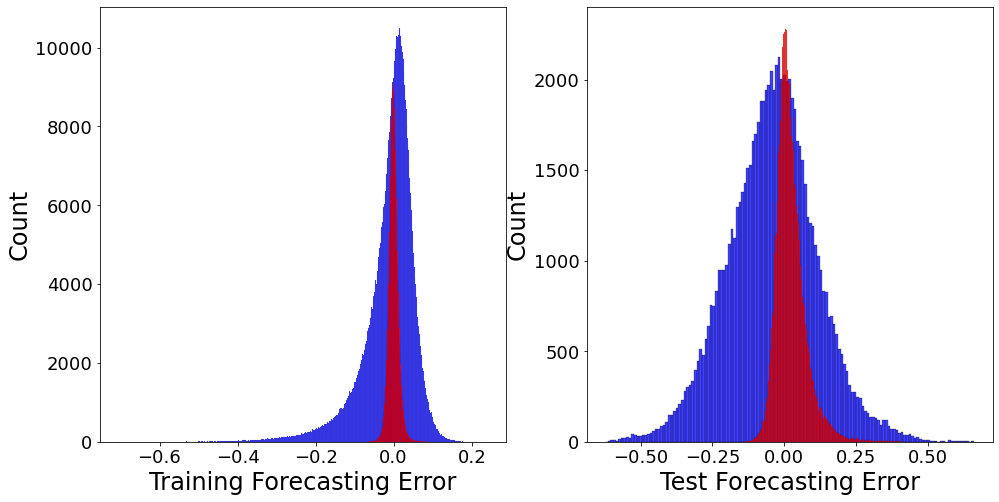

In [14]:
f, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.histplot(data=dat_source, x="Initial_Forecasting_Error", color='blue', ax=ax[0])
sns.histplot(data=dat_source, x="Forecasting_Error", color='red', ax=ax[0])

sns.histplot(data=test_source, x="Initial_Forecasting_Error", color='blue', ax=ax[1])
sns.histplot(data=test_source, x="Forecasting_Error", color='red', ax=ax[1])

ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[0].set_ylabel('Count', fontsize = "24")
a = ax[0].set_xlabel('Training Forecasting Error', fontsize = "24")
ax[1].tick_params(axis='both', which='major', labelsize=18)
ax[1].set_ylabel('Count', fontsize = "24")
a = ax[1].set_xlabel('Test Forecasting Error', fontsize = "24")

f.savefig('GenError_Histogram_FFEL.png', dpi=800, bbox_inches="tight")

In [15]:
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() #

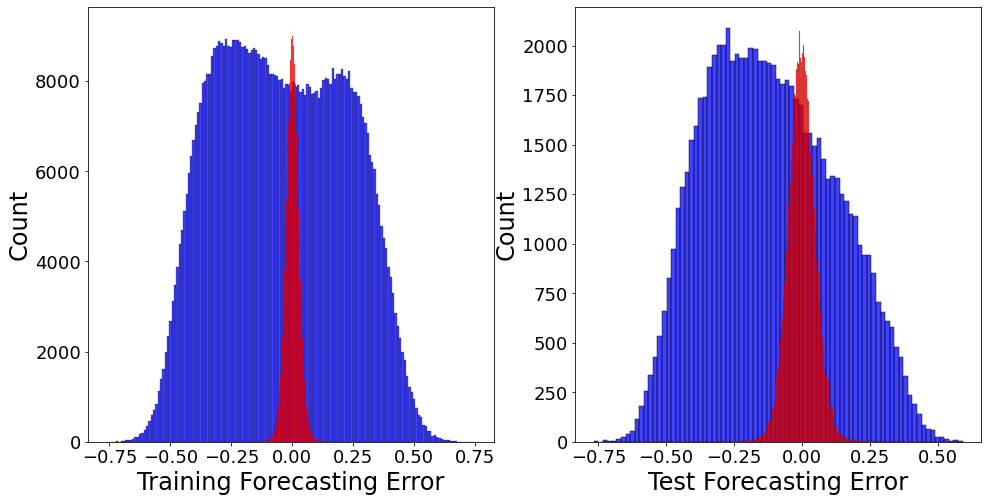

In [16]:
f, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.histplot(data=dat_source, x="Ramp_Initial_Forecasting_Error", color='blue', ax=ax[0])
sns.histplot(data=dat_source, x="Ramp_Forecasting_Error", color='red', ax=ax[0])

sns.histplot(data=test_source, x="Ramp_Initial_Forecasting_Error", color='blue', ax=ax[1])
sns.histplot(data=test_source, x="Ramp_Forecasting_Error", color='red', ax=ax[1])

ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[0].set_ylabel('Count', fontsize = "24")
a = ax[0].set_xlabel('Training Forecasting Error', fontsize = "24")
ax[1].tick_params(axis='both', which='major', labelsize=18)
ax[1].set_ylabel('Count', fontsize = "24")
a = ax[1].set_xlabel('Test Forecasting Error', fontsize = "24")

f.savefig('RampError_Histogram_FFEL.png', dpi=800, bbox_inches="tight")

In [17]:
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() #

## Training/Test Datset Construction

In [18]:
times = np.zeros(dat_source.shape[0], dtype=int)
for i in range(times.shape[0]):
    times[i] = int(i%24)

dat_source['time'] = times
dat_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value,Initial_Forecasting_Error,Real_Ramp_Value,Ramp_Initial_Forecasting_Error,time
0,0.799884,0.777668,-0.022217,0.768020,0.445637,0.458694,0.013057,0.423159,0.009648,0.458694,0.354509,0
1,0.749757,0.739783,-0.009974,0.732273,0.399319,0.425875,0.026556,0.388723,0.007510,0.425875,0.351060,1
2,0.721444,0.721323,-0.000121,0.702248,0.456475,0.470408,0.013932,0.380181,0.019075,0.470408,0.341142,2
3,0.708527,0.710285,0.001759,0.663957,0.541734,0.487425,-0.054309,0.401878,0.046328,0.487425,0.308408,3
4,0.660166,0.672015,0.011849,0.624496,0.493988,0.424991,-0.068997,0.411778,0.047520,0.424991,0.260238,4
...,...,...,...,...,...,...,...,...,...,...,...,...
749107,0.481707,0.475905,-0.005802,0.478220,0.476512,0.437360,-0.039152,0.420162,-0.002315,0.437360,0.055743,19
749108,0.473300,0.464749,-0.008550,0.465869,0.523220,0.487154,-0.036066,0.469672,-0.001120,0.487154,-0.004923,20
749109,0.412981,0.395094,-0.017886,0.444943,0.351557,0.353038,0.001481,0.400793,-0.049849,0.353038,-0.005699,21
749110,0.331719,0.315399,-0.016320,0.436016,0.303514,0.330019,0.026505,0.294662,-0.120617,0.330019,0.020737,22


In [19]:
times = np.zeros(test_source.shape[0], dtype=int)
for i in range(times.shape[0]):
    times[i] = int(i%24)

test_source['time'] = times
test_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value,Initial_Forecasting_Error,Real_Ramp_Value,Ramp_Initial_Forecasting_Error,time
0,0.480779,0.461890,-0.018888,0.432659,0.582004,0.575072,-0.006932,0.577036,0.029231,0.575072,-0.115146,0
1,0.512739,0.508118,-0.004621,0.464848,0.620355,0.618712,-0.001643,0.565822,0.043270,0.618712,-0.057704,1
2,0.563209,0.560342,-0.002868,0.483715,0.641313,0.632459,-0.008853,0.533396,0.076626,0.632459,0.026946,2
3,0.579102,0.597191,0.018089,0.501839,0.606362,0.597212,-0.009151,0.440704,0.095352,0.597212,0.156487,3
4,0.529399,0.557622,0.028223,0.517020,0.410091,0.422014,0.011922,0.416554,0.040602,0.422014,0.141069,4
...,...,...,...,...,...,...,...,...,...,...,...,...
79603,0.237754,0.293595,0.055841,0.402840,0.529685,0.540013,0.010328,0.497580,-0.109244,0.540013,-0.203985,19
79604,0.250278,0.311174,0.060896,0.421850,0.571781,0.553030,-0.018750,0.464331,-0.110677,0.553030,-0.153157,20
79605,0.258552,0.341026,0.082474,0.436025,0.571125,0.581170,0.010045,0.411510,-0.094999,0.581170,-0.070485,21
79606,0.269123,0.370742,0.101619,0.451646,0.477338,0.580858,0.103521,0.398594,-0.080903,0.580858,-0.027851,22


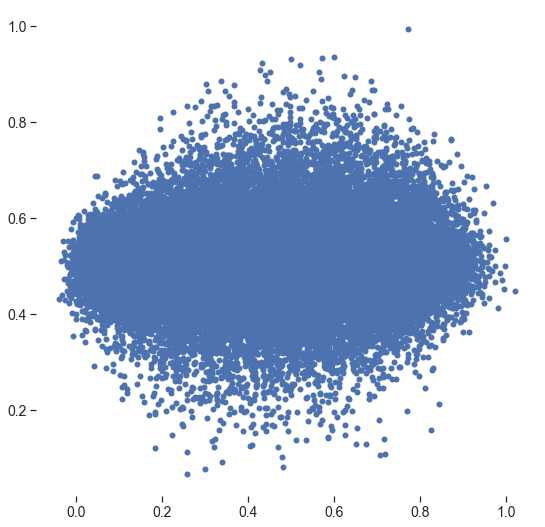

In [249]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(9, 9))

sns.despine(f, left=True, bottom=True)
sns.scatterplot(data=dat_source.loc[dat_source['time']==23], x="Predicted_Value", y="Ramp_Predicted_Value", palette="ch:r=-.2,d=.3_r", linewidth=0, ax=ax)
plt.tick_params(axis='both', which='major', labelsize=14)

a = plt.xlabel('', fontsize=20)
a = plt.ylabel('', fontsize=20)

f.savefig('gpred_vs_rpred_withtime23.png', dpi=1000, bbox_inches="tight")

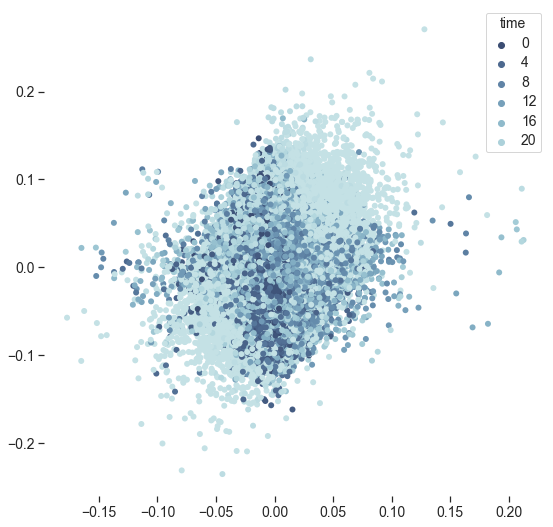

In [180]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(9, 9))

sns.despine(f, left=True, bottom=True)
sns.scatterplot(data=dat_source, x="Forecasting_Error", y="Ramp_Forecasting_Error", palette="ch:r=-.2,d=.3_r", hue='time', linewidth=0, ax=ax)
plt.tick_params(axis='both', which='major', labelsize=14)

a = plt.xlabel('', fontsize=20)
a = plt.ylabel('', fontsize=20)
plt.setp(ax.get_legend().get_texts(), fontsize='14') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title
f.savefig('gerror_vs_rerror_withtime.png', dpi=1000, bbox_inches="tight")

In [21]:
dat_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value,Initial_Forecasting_Error,Real_Ramp_Value,Ramp_Initial_Forecasting_Error,time
0,0.799884,0.777668,-0.022217,0.768020,0.445637,0.458694,0.013057,0.423159,0.009648,0.458694,0.354509,0
1,0.749757,0.739783,-0.009974,0.732273,0.399319,0.425875,0.026556,0.388723,0.007510,0.425875,0.351060,1
2,0.721444,0.721323,-0.000121,0.702248,0.456475,0.470408,0.013932,0.380181,0.019075,0.470408,0.341142,2
3,0.708527,0.710285,0.001759,0.663957,0.541734,0.487425,-0.054309,0.401878,0.046328,0.487425,0.308408,3
4,0.660166,0.672015,0.011849,0.624496,0.493988,0.424991,-0.068997,0.411778,0.047520,0.424991,0.260238,4
...,...,...,...,...,...,...,...,...,...,...,...,...
749107,0.481707,0.475905,-0.005802,0.478220,0.476512,0.437360,-0.039152,0.420162,-0.002315,0.437360,0.055743,19
749108,0.473300,0.464749,-0.008550,0.465869,0.523220,0.487154,-0.036066,0.469672,-0.001120,0.487154,-0.004923,20
749109,0.412981,0.395094,-0.017886,0.444943,0.351557,0.353038,0.001481,0.400793,-0.049849,0.353038,-0.005699,21
749110,0.331719,0.315399,-0.016320,0.436016,0.303514,0.330019,0.026505,0.294662,-0.120617,0.330019,0.020737,22


In [22]:
pair_ini_source = dat_source[['Initial_Predicted_Value', 'Initial_Forecasting_Error', 'Ramp_Initial_Predicted_Value', 'Ramp_Initial_Forecasting_Error', 'time']]

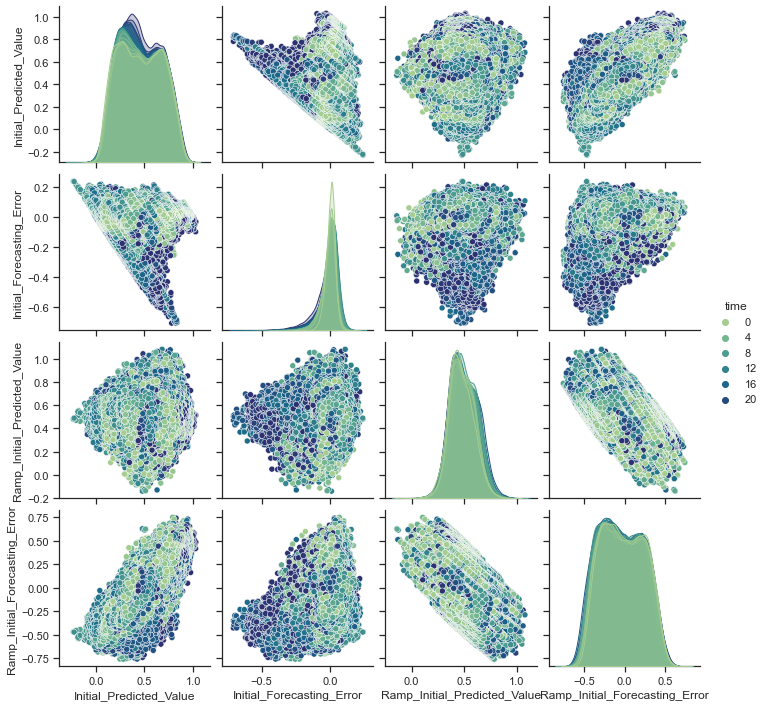

In [23]:
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() #

sns.pairplot(pair_ini_source, palette="crest", hue='time')
plt.savefig('pairplot_ini_with_time.png', dpi=1000, bbox_inches="tight")

In [24]:
pair_source = dat_source[['Predicted_Value', 'Forecasting_Error', 'Ramp_Predicted_Value', 'Ramp_Forecasting_Error', 'time']]

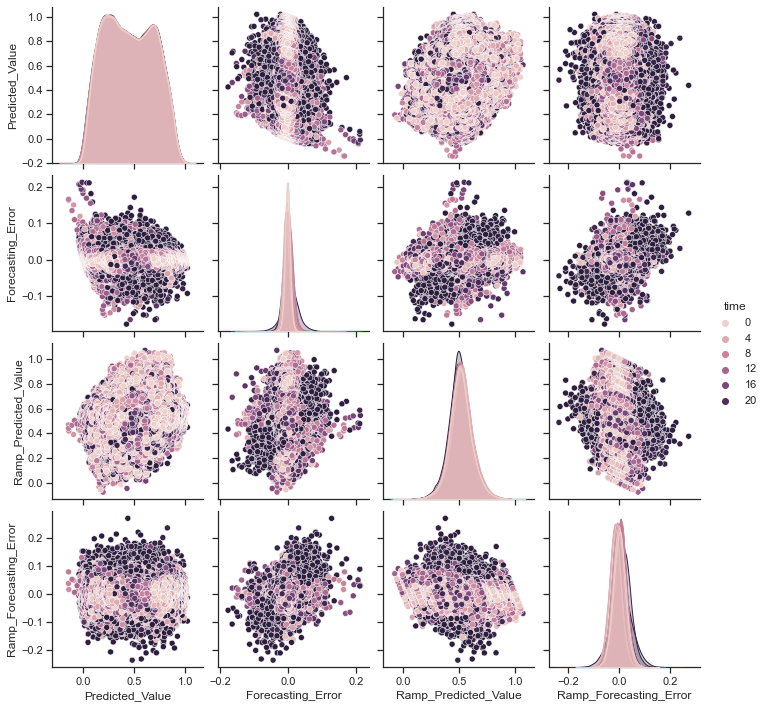

In [25]:
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() #

sns.pairplot(pair_source, hue='time')
plt.savefig('pairplot_with_time.png', dpi=1000, bbox_inches="tight")

In [55]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.square(y_true - y_pred))

def mae(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(abs(y_true - y_pred))

def maemd(y_true, y_pred):
    return np.mean((abs(y_pred - y_true))*np.square(y_true-np.mean(y_true)))*100

def maems(y_true, y_pred):
    return np.mean((abs(y_pred - y_true))*np.square(y_true))*100

In [27]:
tr_source = pd.DataFrame()
tr_source['Predicted_Value'] = dat_source['Predicted_Value']
tr_source['Real_Value'] = dat_source['Predicted_Value']+dat_source['Forecasting_Error']
tr_source['Ramp_Predicted_Value'] = dat_source['Ramp_Predicted_Value']
tr_source['Ramp_Real_Value'] = dat_source['Ramp_Predicted_Value']+dat_source['Ramp_Forecasting_Error']

times = np.zeros(tr_source.shape[0], dtype=int)
for i in range(times.shape[0]):
    times[i] = int(i%24)

tr_source['time'] = times
normtr_source = np.array(tr_source)
normtr_source

array([[ 0.79988438,  0.77766765,  0.44563738,  0.45869445,  0.        ],
       [ 0.74975705,  0.73978324,  0.39931911,  0.42587531,  1.        ],
       [ 0.72144425,  0.72132303,  0.45647538,  0.47040767,  2.        ],
       ...,
       [ 0.41298062,  0.39509437,  0.35155687,  0.35303773, 21.        ],
       [ 0.33171874,  0.31539923,  0.30351388,  0.33001903, 22.        ],
       [ 0.2713494 ,  0.25829484,  0.32778934,  0.38181111, 23.        ]])

In [28]:
tr_source[['Predicted_Value']] = std_scaler.inverse_transform(tr_source[['Predicted_Value']])
tr_source[['Real_Value']] = std_scaler.inverse_transform(tr_source[['Real_Value']])

tr_source[['Ramp_Predicted_Value']] = std_scaler_ramp.inverse_transform(tr_source[['Ramp_Predicted_Value']])
tr_source[['Ramp_Real_Value']] = std_scaler_ramp.inverse_transform(tr_source[['Ramp_Real_Value']])
tr_source

,Predicted_Value,Real_Value,Ramp_Predicted_Value,Ramp_Real_Value,time
0,0.609994,0.593079,-2.228033,-1.794430,0
1,0.571830,0.564236,-3.766184,-2.884298,1
2,0.550274,0.550182,-1.868121,-1.405453,2
3,0.540439,0.541778,0.963175,-0.840336,3
4,0.503620,0.512642,-0.622391,-2.913655,4
...,...,...,...,...,...
749107,0.367752,0.363335,-1.202750,-2.502920,19
749108,0.361351,0.354841,0.348339,-0.849347,20
749109,0.315428,0.301810,-5.352288,-5.303111,21
749110,0.253560,0.241135,-6.947714,-6.067523,22


In [29]:
trgen_pred = np.array(tr_source['Predicted_Value']).reshape(-1,24)
trgen_real = np.array(tr_source['Real_Value']).reshape(-1,24)
trram_pred = np.array(tr_source['Ramp_Predicted_Value']).reshape(-1,24)
trram_real = np.array(tr_source['Ramp_Real_Value']).reshape(-1,24)

trng_pred = np.array(normtr_source[:,0]).reshape(-1,24)
trnr_pred = np.array(normtr_source[:,2]).reshape(-1,24)

In [30]:
tgram = np.zeros(trgen_pred.shape)

for i in range(tgram.shape[0]):
    for j in range(tgram.shape[1]):
        if (i==0) & (j==0):
            gen0 = trgen_real[0,0]-trram_real[0,0]/100
        elif j==0:
            gen0 = trgen_real[i-1,0]
        else:
            gen0 = trgen_pred[i,j-1]
        
        tgram[i,j] = (trgen_pred[i,j]-gen0)*100

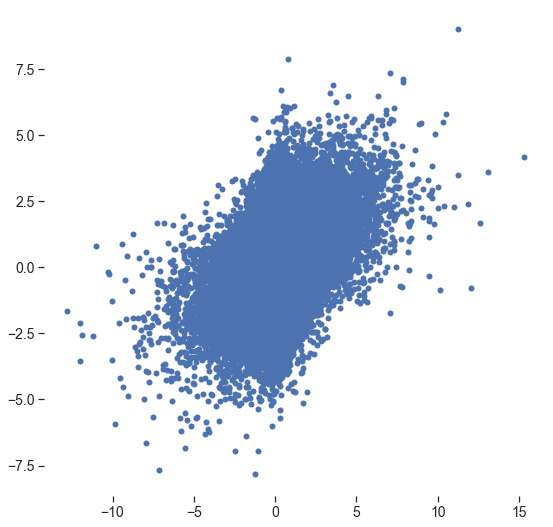

In [31]:
dt1 = pd.DataFrame(np.concatenate([(trram_real-tgram).reshape(-1,1), (trram_real-trram_pred).reshape(-1,1)], axis=1), columns=['er1', 'er2'])

sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(9, 9))

sns.despine(f, left=True, bottom=True)
sns.scatterplot(data=dt1, x='er1', y='er2', palette="ch:r=-.2,d=.3_r", linewidth=0, ax=ax)
plt.tick_params(axis='both', which='major', labelsize=14)
a = plt.xlabel('', fontsize=20)
a = plt.ylabel('', fontsize=20)

### Reconstruction of Original Dataset

In [191]:
t_source = pd.DataFrame()

In [192]:
t_source['Predicted_Value'] = ini_test_source['Predicted_Value']
t_source['Real_Value'] = ini_test_source['Predicted_Value']+ini_test_source['Forecasting_Error']
t_source['Ramp_Predicted_Value'] = ini_test_source['Ramp_Predicted_Value']
t_source['Ramp_Real_Value'] = ini_test_source['Ramp_Predicted_Value']+ini_test_source['Ramp_Forecasting_Error']

times = np.zeros(ini_test_source.shape[0])
for i in range(times.shape[0]):
    times[i] = int(i%24)

t_source['time'] = times

In [193]:
normt_source = np.array(t_source)
normt_source

array([[ 0.48077855,  0.46189047,  0.58200443,  0.57507233,  0.        ],
       [ 0.51273853,  0.50811783,  0.62035453,  0.61871195,  1.        ],
       [ 0.56320918,  0.56034151,  0.64131266,  0.63245924,  2.        ],
       ...,
       [ 0.25855196,  0.34102591,  0.57112509,  0.58117028, 21.        ],
       [ 0.26912308,  0.37074228,  0.47733751,  0.58085847, 22.        ],
       [ 0.32283315,  0.48498374,  0.51806629,  0.77464268, 23.        ]])

In [194]:
t_source[['Predicted_Value']] = std_scaler.inverse_transform(t_source[['Predicted_Value']])
t_source[['Real_Value']] = std_scaler.inverse_transform(t_source[['Real_Value']])

t_source[['Ramp_Predicted_Value']] = std_scaler_ramp.inverse_transform(t_source[['Ramp_Predicted_Value']])
t_source[['Ramp_Real_Value']] = std_scaler_ramp.inverse_transform(t_source[['Ramp_Real_Value']])
t_source

,Predicted_Value,Real_Value,Ramp_Predicted_Value,Ramp_Real_Value,time
0,0.367045,0.352665,2.300487,2.070283,0.0
1,0.391378,0.387860,3.574029,3.519482,1.0
2,0.429803,0.427620,4.270013,3.976006,2.0
3,0.441903,0.455675,3.109374,2.805500,3.0
4,0.404062,0.425549,-3.408454,-3.012528,4.0
...,...,...,...,...,...
79603,0.182020,0.224535,0.563048,0.906008,19.0
79604,0.191555,0.237918,1.960974,1.338303,20.0
79605,0.197855,0.260646,1.939202,2.272786,21.0
79606,0.205903,0.283270,-1.175325,2.262432,22.0


## Combination of Two Forecasting Results

In [195]:
gen_pred = np.array(t_source['Predicted_Value']).reshape(-1,24)
gen_real = np.array(t_source['Real_Value']).reshape(-1,24)
ram_pred = np.array(t_source['Ramp_Predicted_Value']).reshape(-1,24)
ram_real = np.array(t_source['Ramp_Real_Value']).reshape(-1,24)

ng_pred = np.array(normt_source[:,0]).reshape(-1,24)
nr_pred = np.array(normt_source[:,2]).reshape(-1,24)

f_gen = np.zeros(gen_pred.shape)
f_ram = np.zeros(gen_pred.shape)

In [211]:
f_gen = np.zeros(gen_pred.shape)
f_ram = np.zeros(gen_pred.shape)

for i in range(gen_pred.shape[0]):    
    for j in range(gen_pred.shape[1]):
        if (i==0) & (j==0):
            gen0 = gen_real[0,0]-ram_real[0,0]/100
            
        elif j==0:
            gen0 = gen_real[i-1,0]
            
        else:
            gen0 = f_gen[i,j-1]
        
        if ((nr_pred[i,j]<0.2)) | ((nr_pred[i,j]>0.8)):
            rind = 1
        else:
            rind = 0

        if (ng_pred[i,j]>0.8):
            gind = 1
        else:
            gind = 0
            
            
        a = 1/2
        b = 1-a
        
        if gind == 1:
            f_gen[i,j] = gen_pred[i,j]
            f_ram[i,j] = (f_gen[i,j]-gen0)*100
        elif rind == 1:
            f_gen[i,j] = gen0 + ram_pred[i,j]/100
            f_ram[i,j] = ram_pred[i,j]
        else:
            f_gen[i,j] = gen0 + (gen_pred[i,j]-gen0)*a + ram_pred[i,j]/100*b
            f_ram[i,j] = (f_gen[i,j]-gen0)*100

In [217]:
real_gen = np.array(t_source[['Real_Value']])
real_ram = np.array(t_source[['Ramp_Real_Value']])

gen_only = np.array(t_source[['Predicted_Value']])
ram_only = np.array(t_source[['Ramp_Predicted_Value']])

com_gen = f_gen.reshape(-1,1)
com_ram = f_ram.reshape(-1,1)

In [218]:
real_ram = std_scaler_ramp.transform(real_ram)
ram_only = std_scaler_ramp.transform(ram_only)
com_ram = std_scaler_ramp.transform(com_ram)

In [219]:
print('Generation Only Error Test Score > MSE == ', mse(real_gen, gen_only), ' MAE == ', mae(real_gen, gen_only), 'MAPE == ', mape(real_gen, gen_only), ' MAEMS == ', maems(real_gen, gen_only), ' MAEMD == ', maemd(real_gen, gen_only))
print('Combined Generation Error Test Score > MSE == ', mse(real_gen, com_gen), ' MAE == ', mae(real_gen, com_gen), 'MAPE == ', mape(real_gen, com_gen), ' MAEMS == ', maems(real_gen, com_gen), ' MAEMD == ', maemd(real_gen, com_gen))
print('Ramp Rate Only Error Test Score > MSE == ', mse(real_ram, ram_only), ' MAE == ', mae(real_ram, ram_only), 'MAPE == ', mape(real_ram, ram_only), ' MAEMS == ', maems(real_ram, ram_only), ' MAEMD == ', maemd(real_ram, ram_only))
print('Combined Ramp Rate Error Test Score > MSE == ', mse(real_ram, com_ram), ' MAE == ', mae(real_ram, com_ram), 'MAPE == ', mape(real_ram, com_ram), ' MAEMS == ', maems(real_ram, com_ram), ' MAEMD == ', maemd(real_ram, com_ram))

Generation Only Error Test Score > MSE ==  0.0019444594505199646  MAE ==  0.03035837213833323 MAPE ==  15.602542033072393  MAEMS ==  0.4054258233471173  MAEMD ==  0.08858381725429473
Combined Generation Error Test Score > MSE ==  0.0019467538335237616  MAE ==  0.030847340552992604 MAPE ==  16.07308697726413  MAEMS ==  0.40718602212160004  MAEMD ==  0.08922507143970251
Ramp Rate Only Error Test Score > MSE ==  0.0025434314962971705  MAE ==  0.039244335269059745 MAPE ==  7.950189817120407  MAEMS ==  1.0802342504513631  MAEMD ==  0.039112515570334516
Combined Ramp Rate Error Test Score > MSE ==  0.0011367753619559388  MAE ==  0.025058195383332663 MAPE ==  5.067731586715115  MAEMS ==  0.7047792420718876  MAEMD ==  0.02890939207479689


In [220]:
real_gen2 = real_gen[(real_ram>0.8)|(real_ram<0.2)]
gen_only2 = gen_only[(real_ram>0.8)|(real_ram<0.2)]
com_gen2 = com_gen[(real_ram>0.8)|(real_ram<0.2)]
real_ram2 = real_ram[(real_ram>0.8)|(real_ram<0.2)]
ram_only2 = ram_only[(real_ram>0.8)|(real_ram<0.2)]
com_ram2 = com_ram[(real_ram>0.8)|(real_ram<0.2)]

In [221]:
print('Generation Only Error Test Score > MSE == ', mse(real_gen2, gen_only2), ' MAE == ', mae(real_gen2, gen_only2), 'MAPE == ', mape(real_gen2, gen_only2), ' MAEMS == ', maems(real_gen2, gen_only2), ' MAEMD == ', maemd(real_gen2, gen_only2))
print('Combined Generation Error Test Score > MSE == ', mse(real_gen2, com_gen2), ' MAE == ', mae(real_gen2, com_gen2), 'MAPE == ', mape(real_gen2, com_gen2), ' MAEMS == ', maems(real_gen2, com_gen2), ' MAEMD == ', maemd(real_gen2, com_gen2))
print('Ramp Rate Only Error Test Score > MSE == ', mse(real_ram2, ram_only2), ' MAE == ', mae(real_ram2, ram_only2), 'MAPE == ', mape(real_ram2, ram_only2), ' MAEMS == ', maems(real_ram2, ram_only2), ' MAEMD == ', maemd(real_ram2, ram_only2))
print('Combined Ramp Rate Error Test Score > MSE == ', mse(real_ram2, com_ram2), ' MAE == ', mae(real_ram2, com_ram2), 'MAPE == ', mape(real_ram2, com_ram2), ' MAEMS == ', maems(real_ram2, com_ram2), ' MAEMD == ', maemd(real_ram2, com_ram2))

Generation Only Error Test Score > MSE ==  0.005289080691322752  MAE ==  0.05174417270786544 MAPE ==  16.66505733202888  MAEMS ==  0.832077470834678  MAEMD ==  0.08146454595506107
Combined Generation Error Test Score > MSE ==  0.004483354111683008  MAE ==  0.047824613182184554 MAPE ==  15.791805109198155  MAEMS ==  0.7433971753864509  MAEMD ==  0.07639124079144505
Ramp Rate Only Error Test Score > MSE ==  0.004649814054207176  MAE ==  0.050648822641290434 MAPE ==  10.578723819011648  MAEMS ==  3.0333545739000374  MAEMD ==  0.29889163182144163
Combined Ramp Rate Error Test Score > MSE ==  0.0035122531299304947  MAE ==  0.04235292751014338 MAPE ==  8.799364400373616  MAEMS ==  2.5457491372371526  MAEMD ==  0.24497970696728127


In [213]:
final = np.concatenate([com_gen, real_gen, com_ram, real_ram], axis=1)

In [214]:
final = pd.DataFrame(final, columns=['Predicted Generation','Real Generation','Predicted Ramp','Real Ramp'])
final.to_csv('Combined_result_df.csv')

In [224]:
final

,Predicted Generation,Real Generation,Predicted Ramp,Real Ramp
0,0.361006,0.352665,2.904399,2.070283
1,0.394062,0.387860,3.305594,3.519482
2,0.433283,0.427620,3.922059,3.976006
3,0.453140,0.455675,1.985712,2.805500
4,0.411559,0.425549,-4.158111,-3.012528
...,...,...,...,...
79603,0.172693,0.224535,1.495784,0.906008
79604,0.191929,0.237918,1.923602,1.338303
79605,0.204588,0.260646,1.265881,2.272786
79606,0.199369,0.283270,-0.521911,2.262432


In [204]:
dt1 = pd.DataFrame(np.concatenate([real_gen-gen_only, real_ram-ram_only], axis=1), columns=['er1', 'er2'])
dt2 = pd.DataFrame(np.concatenate([real_gen-com_gen, real_ram-com_ram], axis=1), columns=['er1', 'er2'])

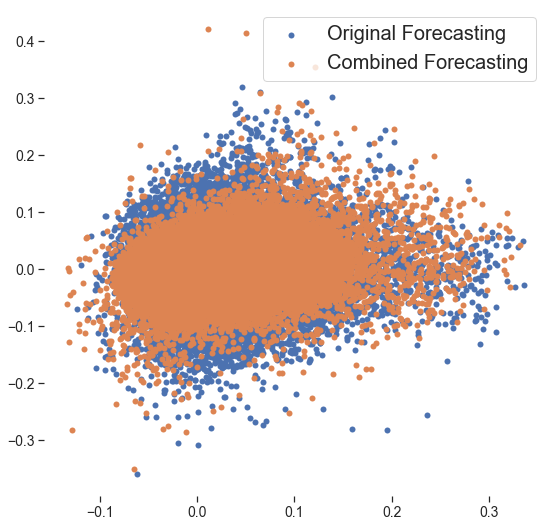

In [205]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(9, 9))

sns.despine(f, left=True, bottom=True)
sns.scatterplot(data=dt1, x='er1', y='er2', palette="ch:r=-.2,d=.3_r", linewidth=0, ax=ax)
sns.scatterplot(data=dt2, x='er1', y='er2', palette="ch:r=-.2,d=.3_r", linewidth=0, ax=ax)
plt.tick_params(axis='both', which='major', labelsize=14)

a = plt.xlabel('', fontsize=20)
a = plt.ylabel('', fontsize=20)
plt.legend(labels=['Original Forecasting','Combined Forecasting'], fontsize=20)

f.savefig('combined_result_error_comparison.png', dpi=1000, bbox_inches="tight")

### Comparison of the proposed method and the case when the generation forecasting is only adopted

In [206]:
gentoram = np.zeros(gen_pred.shape)

for i in range(gentoram.shape[0]):
    for j in range(gentoram.shape[1]):
        if j==0:
            if i==0:
                gen0 = gen_real[0,0]-ram_real[0,0]/100
            else:
                gen0 = gen_real[i-1,0]   
        else:
            gen0 = gen_pred[i,j-1]
            
        gentoram[i,j] = (gen_pred[i,j]-gen0)*100
        
gentoram = gentoram.reshape(-1,1)

In [207]:
gentoram = std_scaler_ramp.transform(gentoram)

In [208]:
print('Ramp Rate Only Error Test Score > MSE == ', mse(real_ram, ram_only), ' MAE == ', mae(real_ram, ram_only), 'MAPE == ', mape(real_ram, ram_only), ' MAEMS == ', maems(real_ram, ram_only))
print('Interpreted From Generation Forecasting Test Score > MSE == ', mse(real_ram, gentoram), ' MAE == ', mae(real_ram, gentoram), 'MAPE == ', mape(real_ram, gentoram), ' MAEMS == ', maems(real_ram, gentoram))
print('Combined Ramp Rate Error Test Score > MSE == ', mse(real_ram, com_ram), ' MAE == ', mae(real_ram, com_ram), 'MAPE == ', mape(real_ram, com_ram), ' MAEMS == ', maems(real_ram, com_ram))

Ramp Rate Only Error Test Score > MSE ==  0.0025434314962971705  MAE ==  0.039244335269059745 MAPE ==  7.950189817120407  MAEMS ==  1.0802342504513631
Interpreted From Generation Forecasting Test Score > MSE ==  0.0012679029510912047  MAE ==  0.025938564463991304 MAPE ==  5.272665982856253  MAEMS ==  0.7223107121383054
Combined Ramp Rate Error Test Score > MSE ==  0.0011367753619559388  MAE ==  0.025058195383332663 MAPE ==  5.067731586715115  MAEMS ==  0.7047792420718876


In [209]:
gentoram2 = gentoram[(real_ram>0.8)|(real_ram<0.2)]

In [210]:
print('Ramp Rate Only Error Test Score > MSE == ', mse(real_ram2, ram_only2), ' MAE == ', mae(real_ram2, ram_only2), 'MAPE == ', mape(real_ram2, ram_only2), ' MAEMS == ', maems(real_ram2, ram_only2))
print('Interpreted From Generation Forecasting Test Score > MSE == ', mse(real_ram2, gentoram2), ' MAE == ', mae(real_ram2, gentoram2), 'MAPE == ', mape(real_ram2, gentoram2), ' MAEMS == ', maems(real_ram2, gentoram2))
print('Combined Ramp Rate Error Test Score > MSE == ', mse(real_ram2, com_ram2), ' MAE == ', mae(real_ram2, com_ram2), 'MAPE == ', mape(real_ram2, com_ram2), ' MAEMS == ', maems(real_ram2, com_ram2))

Ramp Rate Only Error Test Score > MSE ==  0.004649814054207176  MAE ==  0.050648822641290434 MAPE ==  10.578723819011648  MAEMS ==  3.0333545739000374
Interpreted From Generation Forecasting Test Score > MSE ==  0.0048464637264479665  MAE ==  0.05095826083589884 MAPE ==  10.60048687756472  MAEMS ==  3.043335508108929
Combined Ramp Rate Error Test Score > MSE ==  0.0035122531299304947  MAE ==  0.04235292751014338 MAPE ==  8.799364400373616  MAEMS ==  2.5457491372371526
